In [1]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   --- ------------------------------------ 6.0/72.0 MB 37.0 MB/s eta 0:00:02
   ------ --------------------------------- 12.6/72.0 MB 34.2 MB/s eta 0:00:02
   ------------ --------------------------- 22.3/72.0 MB 38.1 MB/s eta 0:00:02
   ------------------ --------------------- 33.8/72.0 MB 43.0 MB/s eta 0:00:01
   ------------------------ --------------- 43.5/72.0 MB 43.3 MB/s eta 0:00:01
   ------------------------------ --------- 54.5/72.0 MB 44.5 MB/s eta 0:00:01
   ----------------------------------- ---- 64.5/72.0 MB 45.2 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 45.4 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 42.5 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [40]:
prices = pd.read_csv("../data/raw/prices_raw.csv", parse_dates=[0], index_col=0)
stock_returns = prices.resample('ME').last().pct_change().dropna()

factors = pd.read_csv("../data/raw/fama_french_factors.csv", parse_dates=[0], index_col=0)
factors.rename(columns={
    "Mkt-RF": "MKT_RF",
    "SMB": "SMB",
    "HML": "HML",
    "RMW": "RMW",
    "CMA": "CMA",
    "RF": "RF"
}, inplace=True)
factors_monthly = factors.resample('ME').apply(lambda x: (1 + x).prod() - 1)
final_df = stock_returns.join(factors_monthly, how='inner')

final_df.index.name = 'date'
factor_cols = list(factors_monthly.columns)
final_df = final_df.reset_index().melt(
    id_vars=['date'] + factor_cols, 
    var_name='Ticker', 
    value_name='Return'
)

final_df = final_df.sort_values(['Ticker', 'date'])
final_df['Momentum_1M'] = final_df['Return']
final_df['Excess_Return'] = final_df['Return'] - final_df['RF']
final_df['Next_Month_Return'] = final_df.groupby('Ticker')['Excess_Return'].shift(-1)
final_df = final_df.dropna(subset=['Next_Month_Return', 'Momentum_1M'])
print(f"Data Loaded. Shape: {final_df.shape}")
final_df.head()

Data Loaded. Shape: (3290, 12)


,date,MKT_RF,SMB,HML,RMW,CMA,RF,Ticker,Return,Momentum_1M,Excess_Return,Next_Month_Return
0,2019-02-28,0.034291,0.017248,-0.025807,0.000938,-0.014958,0.001902,AAPL,0.044776,0.044776,0.042875,0.094924
1,2019-03-31,0.010810,-0.034384,-0.041612,0.008226,-0.009112,0.002102,AAPL,0.097026,0.097026,0.094924,0.054334
2,2019-04-30,0.039545,-0.011169,0.020522,0.015536,-0.021350,0.002102,AAPL,0.056436,0.056436,0.054334,-0.126415
3,2019-05-31,-0.069063,-0.016595,-0.026942,-0.005545,0.018272,0.002202,AAPL,-0.124213,-0.124213,-0.126415,0.128517
4,2019-06-30,0.069085,0.003494,-0.006747,0.008224,-0.004484,0.002002,AAPL,0.130519,0.130519,0.128517,0.074192


In [41]:
X = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Momentum_1M']
y = 'Next_Month_Return'

In [42]:
cutoff_index = int(len(final_df) * 0.8)
cutoff_date = final_df.iloc[cutoff_index]['date']

print(f"Training XGBoost on data before: {cutoff_date}")

# Split
train_df = final_df[final_df['date'] < cutoff_date]
test_df = final_df[final_df['date'] >= cutoff_date]

X_train = train_df[X]
y_train = train_df[y]
X_test = test_df[X]
y_test = test_df[y]

print(f"Train Size: {X_train.shape}, Test Size: {X_test.shape}")

Training XGBoost on data before: 2022-08-31 00:00:00
Train Size: (1974, 6), Test Size: (1316, 6)


XGBoost Model Trained.


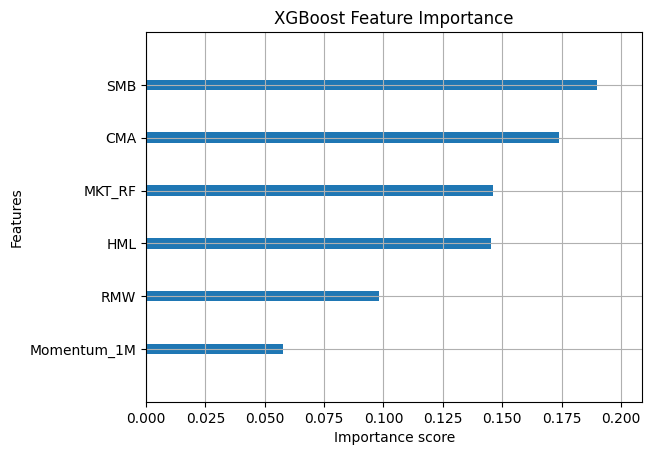

In [43]:
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,            
    learning_rate=0.05,     
    objective='reg:squarederror',        
    random_state=42
)

xgb_model.fit(X_train, y_train)
print("XGBoost Model Trained.")
xgb.plot_importance(xgb_model, importance_type='gain', show_values=False, title='XGBoost Feature Importance')
plt.show()

In [ ]:
preds = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("--- XGBoost Regression Metrics ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R-squared (R²):                 {r2:.4f}")

--- XGBoost Regression Metrics ---
Root Mean Squared Error (RMSE): 0.0950
Mean Absolute Error (MAE):      0.0722
R-squared (R²):                 -0.1789


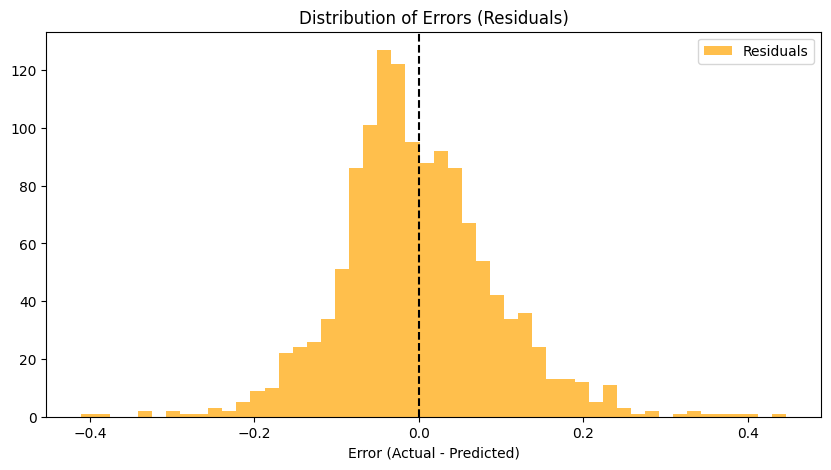

In [47]:
plt.figure(figsize=(10, 5))
residuals = y_test - preds
plt.hist(residuals, bins=50, color='orange', alpha=0.7, label='Residuals')
plt.axvline(0, color='black', linestyle='--')
plt.title('Distribution of Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.legend()
plt.show()

In [44]:
# Chat-GPT suggested evaluation code
from scipy.stats import spearmanr

preds = xgb_model.predict(X_test)
results = pd.DataFrame({'date': test_df['date'],'Ticker': test_df['Ticker'],'Actual': y_test,'Predicted': preds})


def get_ic(group):
    if len(group) < 2: 
            return np.nan
    return spearmanr(group['Actual'], group['Predicted'])[0]

ic_series = results.groupby('date').apply(get_ic)
mean_ic = ic_series.mean()
ic_std = ic_series.std()
annualized_ir = mean_ic / ic_std * np.sqrt(12)

print(f"--- XGBoost Performance ---")
print(f"Mean IC:             {mean_ic:.4f}")
print(f"Annualized IR:       {annualized_ir:.4f}")


--- XGBoost Performance ---
Mean IC:             -0.0026
Annualized IR:       -0.0584


C:\Users\mshri\AppData\Local\Temp\ipykernel_17864\2717544371.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_series = results.groupby('date').apply(get_ic)


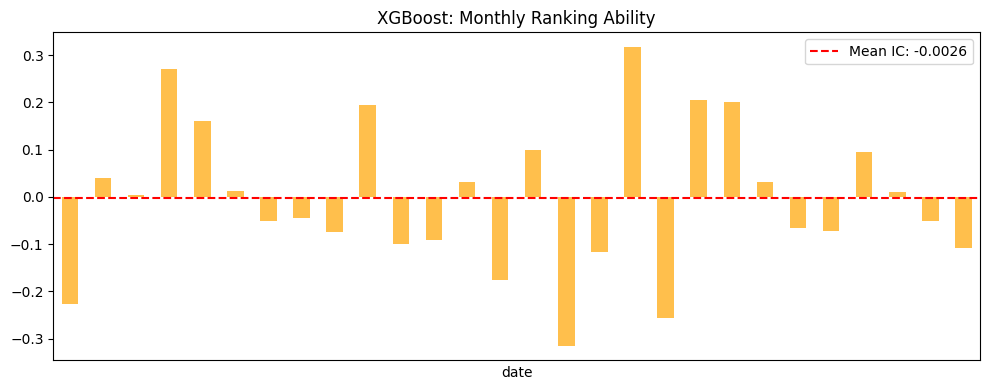

In [45]:
plt.figure(figsize=(10, 4))
ic_series.plot(kind='bar', color='orange', alpha=0.7)
plt.axhline(mean_ic, color='red', linestyle='--', label=f'Mean IC: {mean_ic:.4f}')
plt.title('XGBoost: Monthly Ranking Ability')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()